In [1]:
%matplotlib inline

####  生成数据并显示

In [10]:
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd, nd
import random

In [3]:
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = nd.random.normal(scale=1, shape=(num_examples, num_inputs))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += nd.random.normal(scale=0.01, shape=labels.shape)

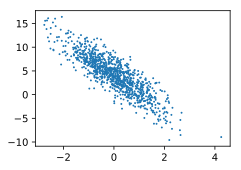

In [4]:
def use_svg_display():
    display.set_matplotlib_formats('svg')
def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
set_figsize()
plt.scatter(features[:, 1].asnumpy(), labels.asnumpy(), 1);

#### 读取数据

In [6]:
def data_iter(batch_sizes, features, lables):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_sizes):
        j = nd.array(indices[i : min(i+batch_sizes, num_examples)])
        yield features.take(j), labels.take(j)

In [7]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break


[[-2.0918664e-01 -1.5221572e-01]
 [ 7.6649487e-01  3.6059555e-01]
 [-5.4200366e-04 -4.7270110e-01]
 [-1.3409485e+00  9.3852139e-01]
 [-9.5236367e-01  9.2881453e-01]
 [-2.3028238e+00  1.6881204e+00]
 [ 4.8569438e-01 -1.1895581e+00]
 [ 2.0452461e+00  5.1844931e-01]
 [-4.4089764e-01 -1.0183921e+00]
 [-1.2186161e+00  9.9805301e-01]]
<NDArray 10x2 @cpu(0)> 
[ 4.310295    4.5019956   5.807947   -1.6516552  -0.87666404 -6.155135
  9.220327    6.5239625   6.7752595  -1.6386467 ]
<NDArray 10 @cpu(0)>


#### 初始化模型参数

In [8]:
w = nd.random.normal(scale=0.01, shape=(num_inputs, 1))
b = nd.zeros(shape=(1, ))
w.attach_grad()
b.attach_grad()

In [12]:
def linearRegression(X, w, b):
    return nd.dot(X, w) + b
    
def squared_loss(y_hat, y): 
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def sgd(params, lr, batch_size): 
    for param in params:
        param[:] = param - lr * param.grad / batch_size

####  使用自动求梯度训练模型

In [20]:
learningRate = 0.03
num_epochs = 5
net = linearRegression
loss = squared_loss
for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X, w, b), y)
        l.backward()
        sgd([w, b], learningRate, batch_size)
    train_l = loss(net(features, w, b), labels)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().asnumpy()))

epoch 1, loss 0.000048
epoch 2, loss 0.000048
epoch 3, loss 0.000048
epoch 4, loss 0.000048
epoch 5, loss 0.000048


#### 简洁实现线性回归

In [21]:
from mxnet.gluon import data as gdata

In [22]:
batch_size = 10
# 把标签和数据组合在一起
dataset = gdata.ArrayDataset(features, labels)
data_iter = gdata.DataLoader(dataset, batch_size, shuffle=True)

In [23]:
from mxnet.gluon import nn

In [25]:
net = nn.Sequential()
net.add(nn.Dense(1))
from mxnet import init
from mxnet.gluon import loss as gloss

In [26]:
net.initialize(init.Normal(sigma=0.01))
loss = gloss.L2Loss()
from mxnet import gluon

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.03})

In [27]:

num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        with autograd.record():
            l = loss(net(X), y)
        l.backward()
        trainer.step(batch_size)
    l = loss(net(features), labels)
    print('epoch %d, loss: %f' % (epoch, l.mean().asnumpy()))

epoch 1, loss: 0.035099
epoch 2, loss: 0.000124
epoch 3, loss: 0.000048
